<a href="https://colab.research.google.com/github/hanmaegeo/Forest-Cover-Type-Prediction/blob/main/project_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# w207 Project Baseline
## Forest Cover Type Prediction

**Authors:** Raul Merino, Hannah George, and Rohan Mendiratta

[Kaggle Competition Link](https://www.kaggle.com/c/forest-cover-type-prediction)

## Introduction

In this project we will attempt to predict the forecast cover type from cartographic data. 

The seven types of forest covers are:

*   Spruce/Fir
*   Lodgepole Pine
*   Ponderosa Pine
*   Cottonwood/Willow
*   Aspen
*   Douglas-fir
*   Krummholz

And the data fields we will use attempt to predict these forest cover types are:
*   Elevation - Elevation in meters.
*   Aspect - Aspect in degrees azimuth.
*   Slope - Slope in degrees.
*   Horizontal_Distance_To_Hydrology - Hoizontal distance to nearest surface water features.
*   Vertical_Distance_To_Hydrology - Vertical distance to nearest surface water features.
*   Horizontal_Distance_To_Roadways - Horzontal distance to nearest roadway.
*   Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice.
*   Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice.
*   Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice.
*   Horizontal_Distance_To_Fire_Points - Horzontal distance to nearest wildfire ignition points.
*   Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation.
*   Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation.

## Project Setup

### Imports

In [15]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Load in Data

In [3]:
base_url = 'https://raw.githubusercontent.com/hanmaegeo/Forest-Cover-Type-Prediction/main'
train_url = base_url + '/train.csv'
test_url = base_url + '/test.csv'

train_dataset = pd.read_csv(train_url)
test_dataset = pd.read_csv(test_url)

In [13]:
train_dataset.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [14]:
test_dataset.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,6675,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,6344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,6374,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,6404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis

In [23]:
r, c = train_dataset.shape
print(f'There are {r} rows and {c} columns')
train_dataset.describe()

There are 15120 rows and 56 columns


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,-2.132627e-16,5.078977e-17,2.731501e-17,-3.494493e-15,-3.594163e-16,2.109424e-16,-4.168256e-16,5.516164e-16,9.195319e-17,4.146742e-16,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,-2.122093e+00,-1.423270e+00,-1.952008e+00,-1.081532e+00,-3.218239e+00,-1.293580e+00,-6.960156e+00,-5.261370e+00,-2.943587e+00,-1.373895e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,-8.938338e-01,-8.328021e-01,-7.690867e-01,-7.625885e-01,-7.524248e-01,-7.169865e-01,-5.466017e-01,-5.247795e-01,-6.339000e-01,-7.101984e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,6.410523e-03,-2.786705e-01,-1.776260e-01,-2.246683e-01,-3.115176e-01,-3.003898e-01,2.387315e-01,1.769376e-01,6.336391e-02,-2.319731e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000

The first column is just a sequential id, which isn't really useful.
There aren't any empty values, as all of the columns have counts equal to the number of rows. There are 40 Soil Types, and 4 Wilderness Areas.
Soil_Type7 and Soil_Type15 have standard deviations of 0 which means they are constant, and it seems in both cases the values are 0. Since these are Dummy variable this means that no trees in our database have those soil types.

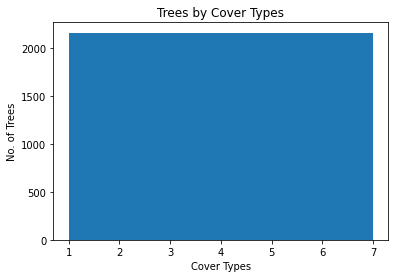

In [24]:
plt.hist(train_dataset['Cover_Type'], bins=train_dataset['Cover_Type'].max())

plt.xlabel("Cover Types")
plt.ylabel("No. of Trees")
plt.title("Trees by Cover Types")
plt.show()

As it can be seen in the previous histogram, the cover types are evenly distributed in our dataset.

In [25]:
data_corr = train_dataset.corr()
data_corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,1.000000,0.185496,0.017702,-0.020168,0.099637,0.055348,-0.033028,0.000786,0.073123,0.042524,-0.068739,-0.339861,0.158484,0.384219,-0.158451,-0.058451,0.045545,-0.045757,0.118214,-0.041713,-0.046017,nan,-0.013159,-0.014219,0.032292,0.063372,-0.129930,0.015145,-0.016034,nan,-0.003794,-0.002940,-0.070252,-0.029707,-0.069537,0.014734,0.035739,-0.017422,0.034019,0.005675,0.031176,0.024141,-0.005104,-0.231780,-0.157515,0.025826,0.068048,0.066887,0.022520,0.057480,0.009110,0.016040,0.086932,0.083376,0.122475,0.108363
Elevation,0.185496,1.000000,-0.011096,-0.312640,0.412712,0.122092,0.578659,0.097900,0.215782,0.089518,0.443563,0.330417,0.261729,0.354025,-0.783651,-0.218818,-0.147947,-0.307523,-0.125342,-0.141478,-0.187354,nan,0.002934,-0.010571,-0.357816,-0.037906,0.017432,0.039304,-0.140619,nan,-0.066252,-0.200663,-0.035173,0.029808,0.008548,0.032509,0.146236,0.159872,0.097647,0.010586,0.020669,0.040019,-0.001077,0.165304,0.048204,0.093191,0.172349,0.123821,0.021876,0.120157,0.040571,0.073825,0.323440,0.296405,0.306755,0.016090
Aspect,0.017702,-0.011096,1.000000,0.028148,0.040732,0.056412,0.066184,-0.593997,0.324912,0.635022,-0.052169,-0.131262,0.028238,0.032578,0.075228,-0.024538,-0.020970,-0.069120,0.018019,0.000343,-0.006066,nan,0.001723,-0.019391,0.111959,-0.034549,-0.044142,0.024312,0.001181,nan,0.027121,0.029870,-0.042140,0.007570,-0.023330,0.018815,0.022301,0.041880,0.005480,-0.002340,-0.009775,0.018986,0.026330,-0.063428,-0.086897,0.008160,0.003700,0.018719,0.012927,-0.004235,0.003160,-0.046309,0.043860,-0.031342,0.007208,0.008015
Slope,-0.020168,-0.312640,0.028148,1.000000,-0.055976,0.265314,-0.277049,-0.200072,-0.612613,-0.326887,-0.239527,-0.152820,-0.065923,-0.113033,0.286985,0.099355,-0.081498,0.265541,0.087841,0.074720,-0.047868,nan,-0.012989,-0.022220,0.255804,-0.109798,-0.115088,0.119863,-0.054085,nan,-0.064321,-0.124375,-0.069326,-0.047742,-0.068508,-0.033935,-0.076393,-0.184528,0.017982,0.011062,-0.030700,0.012295,0.036082,-0.083108,0.118725,-0.076851,-0.147258,0.072027,-0.030590,-0.048855,-0.004570,0.003129,-0.148342,0.051900,-0.043513,0.087722
Horizontal_Distance_To_Hydrology,0.099637,0.412712,0.040732,-0.055976,1.000000,0.652142,0.203397,-0.033803,0.080047,0.080833,0.158817,-0.009402,0.087484,0.200532,-0.239303,-0.084766,0.024234,-0.089578,-0.059398,-0.025247,0.021203,nan,0.002819,-0.005523,-0.112852,0.026150,0.034306,0.026595,-0.111878,nan,-0.084804,-0.159717,-0.018282,-0.033946,-0.062873,-0.025207,-0.007840,-0.087963,0.046915,-0.004615,0.027879,0.064616,0.019663,0.033854,-0.032540,0.060886,0.138275,0.062121,0.072485,-0.015446,0.077251,-0.009549,0.131444,0.066284,0.242304,-0.010515
Vertical_Distance_To_Hydrology,0.055348,0.122092,0.056412,0.265314,0.652142,1.000000,0.011555,-0.095930,-0.132948,-0.035559,-0.015048,-0.117835,0.017108,0.069884,0.027321,-0.034309,0.005436,0.070414,-0.016543,0.018550,0.094701,nan,-0.007049,-0.014610,0.018305,-0.029364,-0.033237,0.085309,-0.087445,nan,-0.070201,-0.155574,-0.039745,-0.040898,-0.065710,-0.022197,-0.064122,-0.144317,0.017148,-0.011697,-0.016315,0.047304,0.046287,-0.056267,-0.000083,0.006247,0.020298,0.077167,0.028910,-0.021662,0.015680,-0.020717,-0.008989,0.058981,0.227110,0.075647
Horizontal_Distance_To_Roadways,-0.033028,0.578659

If we look at the correlation matrix we can notice right away that Soil_Type7 and Soil_Type15 have NaN as their values. This makes sense since they all have values of 0, which given the correlation formula would make the denominator 0 as well.

We can also see some important correlation values, such as Elevation and Wilderness_Area4, which a very high negative correlation, which likely means that most of that area has low elevation, while Horizontal_Distance_To_Roadways has a relatively high positive correlation, which we can interpret as the elevation increasing the further away a tree is from a roadway.

Hillshade_9am and Hillshade_3pm seem to be very negatively correlated, the difference likely comes from the fact that the sun is in opposites sides at each of those times.

We don't observe any major correlation with the over type, which makes sense since Cover_Type is a categorical variable, so there's no real order between them.

In [26]:
cover_dummies = pd.get_dummies(train_dataset['Cover_Type'])
new_dataset = pd.concat([cover_dummies, train_dataset], axis=1)
data_corr = new_dataset.corr()
data_corr[cover_dummies.columns].style.background_gradient(cmap='coolwarm')

,1,2,3,4,5,6,7
1,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667
2,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667
3,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667
4,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667
5,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667
6,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667
7,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000
Id,0.040741,-0.116710,0.053037,-0.112792,-0.100426,0.046842,0.189310
Elevation,0.370166,0.169313,-0.342989,-0.514046,0.036634,-0.318695,0.599617
Aspect,0.010335,-0.020692,0.063031,-0.068895,-0.069293,0.088785,-0.003272


By looking at just the correlation of each indididual cover type with the rest of our variables we can see that some of them have clear relationships between them. Such as trees with cover type 7 having high elevation, while those with cover type 4 having low elevation given their high negstive correlation.

We can also see that certain wilderness areas and soil types have more noticeable correlations with the cover types, such as cover type 4 with area4 and soil type 3.

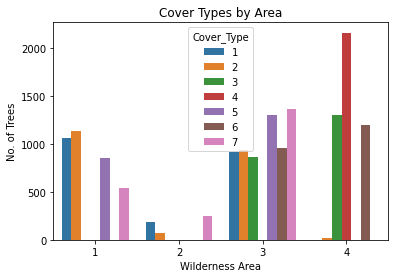

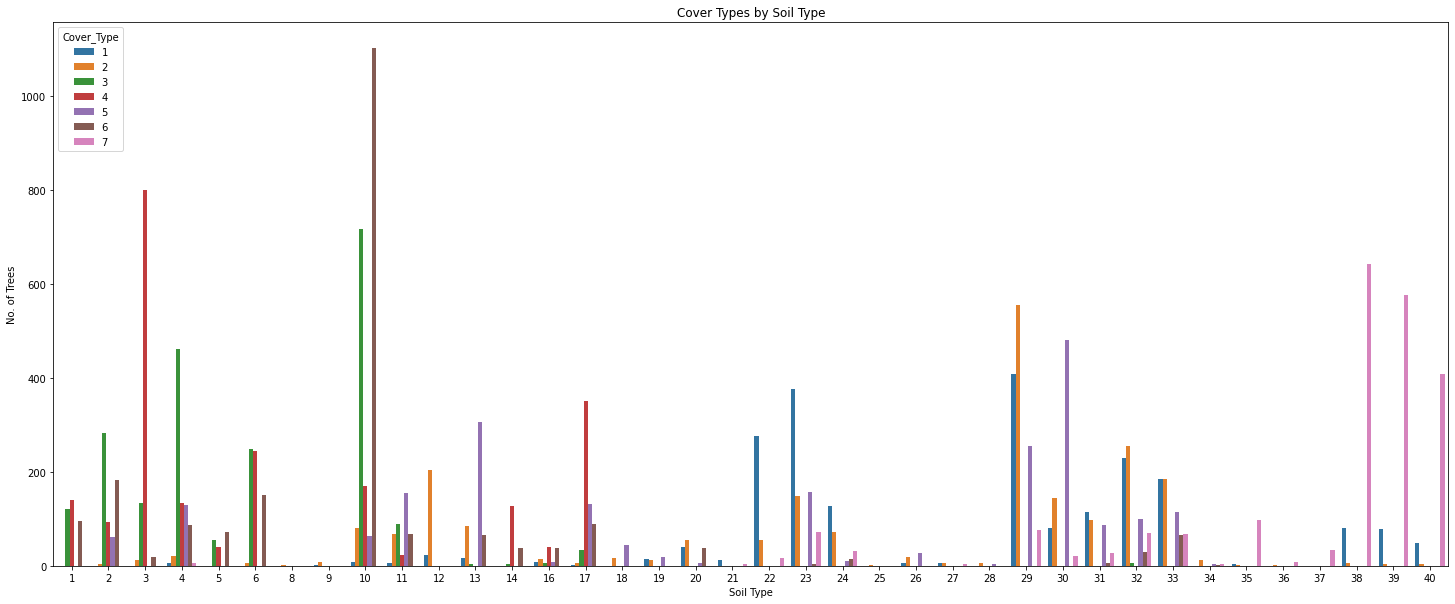

In [27]:
data = pd.DataFrame(index=numpy.arange(0, r),columns=['Wilderness_Area','Soil_Type','Cover_Type'])

for i in range(4):
    data['Wilderness_Area'] = numpy.where(train_dataset[f'Wilderness_Area{i+1}'],i+1,data['Wilderness_Area'])
    
for i in range(40):
    data['Soil_Type'] = numpy.where(train_dataset[f'Soil_Type{i+1}'],i+1,data['Soil_Type'])

data['Cover_Type'] = train_dataset['Cover_Type']

#Plot for Category1    
sns.countplot(x="Wilderness_Area", hue="Cover_Type", data=data)
plt.xlabel("Wilderness Area")
plt.ylabel("No. of Trees")
plt.title("Cover Types by Area")
plt.show()
#Plot for Category2
plt.rc("figure", figsize=(25, 10))
sns.countplot(x="Soil_Type", hue="Cover_Type", data=data)
plt.xlabel("Soil Type")
plt.ylabel("No. of Trees")
plt.title("Cover Types by Soil Type")
plt.show()

Continuing with what was found in the correlation matrix, we see that some cover types are only found in certain areas. The clearest example is Cover Type 4 which can only be found in Area 4.

Something similar can be appreciated with soil type, some cover types represent a really big percentage of certain soil types.

## Data Cleaning

### Check for Nulls

In [9]:
train_dataset.isna().sum().sum()

0

In [8]:
test_dataset.isna().sum().sum()

0

There are no null values in the either the training data or the testing dataset to worry about.

### Scale Continuous Columns

In [16]:
continuous_columns = [
  'Elevation',
  'Aspect',
  'Slope',
  'Horizontal_Distance_To_Hydrology',
  'Vertical_Distance_To_Hydrology',
  'Horizontal_Distance_To_Roadways',
  'Hillshade_9am',
  'Hillshade_Noon',
  'Hillshade_3pm',
  'Horizontal_Distance_To_Fire_Points'
]
scaler = StandardScaler()
train_dataset[continuous_columns] = scaler.fit_transform(train_dataset[continuous_columns])
test_dataset[continuous_columns] = scaler.transform(test_dataset[continuous_columns])

### Train/Dev/Test Split

In [21]:
x_test = test_dataset

x_train = train_dataset.loc[:, train_dataset.columns != 'Cover_Type']
y_train = train_dataset['Cover_Type']

x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, random_state=0, shuffle=False)